In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run(c))

Instructions for updating:
non-resource variables are not supported in the long term
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7

[[22. 28.]
 [49. 64.]]


In [2]:
!mkdir train_local
!wget http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz
!tar zxvf stl10_binary.tar.gz -C train_local
!rm stl10_binary.tar.gz

--2021-11-05 06:08:36--  http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2640397119 (2.5G) [application/x-gzip]
Saving to: ‘stl10_binary.tar.gz’

stl10_binary.tar.gz 100%[===================>]   2.46G  54.5MB/s    in 75s     

2021-11-05 06:09:50 (33.7 MB/s) - ‘stl10_binary.tar.gz’ saved [2640397119/2640397119]

stl10_binary/
stl10_binary/test_X.bin
stl10_binary/test_y.bin
stl10_binary/train_X.bin
stl10_binary/train_y.bin
stl10_binary/unlabeled_X.bin
stl10_binary/class_names.txt
stl10_binary/fold_indices.txt


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from keras.utils.data_utils import get_file


import os
import sys
import tarfile

In [4]:
DATA_DIR = '/content/train_local/stl10_binary'
DATA_URL = 'http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz'
def read_labels(path_to_labels):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels
    
def read_all_images(path_to_data):
    with open(path_to_data,'rb') as f:
# We force the data into 3x96x96 chunks, since the
# images are stored in "column-major order", meaning
# that "the first 96*96 values are the red channel,
# the next 96*96 are green, and the last are blue."
# The -1 is since the size of the pictures depends
# on the input file, and this way numpy determines
# the size on its own

        all_images=np.fromfile(f,dtype=np.uint8)
        images=np.reshape(all_images,(-1,3,96,96))
        images=np.transpose(images,(0,3,2,1))
        return images

def read_single_image(image_file):
    """
    CAREFUL! - this method uses a file as input instead of the path - so the
    position of the reader will be remembered outside of context of this method.
    :param image_file: the open file containing the images
    :return: a single image
    """
    # read a single image, count determines the number of uint8's to read
    image = np.fromfile(image_file, dtype=np.uint8, count=SIZE)
    # force into image matrix
    image = np.reshape(image, (3, 96, 96))
    # transpose to standard format
    # You might want to comment this line or reverse the shuffle
    # if you will use a learning algorithm like CNN, since they like
    # their channels separated.
    image = np.transpose(image, (2, 1, 0))
    return image



def load_data():
    # download data if needed
    path = get_file(DATA_DIR, origin=DATA_URL, untar=True)

    # test to check if the whole dataset is read correctly
    # path to the binary train file with image data
    train_data_path = os.path.join(path, '/content/train_local/stl10_binary/train_X.bin')

    # path to the binary train file with labels
    train_label_path = os.path.join(path, '/content/train_local/stl10_binary/train_y.bin')

    # path to the binary test file with image data
    test_data_path = os.path.join(path, '/content/train_local/stl10_binary/test_X.bin')

    # path to the binary test file with labels
    test_label_path = os.path.join(path, '/content/train_local/stl10_binary/test_y.bin')

    x_train = read_all_images(train_data_path)
    print(x_train.shape)

    y_train = read_labels(train_label_path)
    print(y_train.shape)

    x_test = read_all_images(test_data_path)
    print(x_test.shape)

    y_test = read_labels(test_label_path)
    print(y_test.shape)

    return (x_train, y_train), (x_test, y_test)


In [5]:
x=read_all_images('/content/train_local/stl10_binary/train_X.bin')
print(x.shape)

(5000, 96, 96, 3)


In [6]:
import numpy as np
from keras import layers
from keras.layers import Input,Add,Dense,Activation,ZeroPadding2D,BatchNormalization,Flatten,Conv2D,AveragePooling2D,MaxPooling2D
from keras.models import Model,load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
import scipy.misc
from matplotlib.pyplot import imshow
# from keras.utils import plot_model

In [7]:
# x is input, y=F(x)
# identity block simply means input should be equal to output. 
#  y = x + F(x)   the layers in a traditional network are learning the true output H(x)
# F(x) = y - x   the layers in a residual network are learning the residual F(x)
# Hence, the name: Residual Block.


def identity_block(x,f,filters):
    """
   
    Arguments:
    X -- input of shape (m, height, width, channel)
    f -- shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    F1,F2,F3=filters
    x_skip=x
    
    #first layer
    x=Conv2D(filters=F1,kernel_size=(1,1),strides=(1,1),padding='valid')(x)
    x=BatchNormalization(axis=3)(x)
    x=Activation('relu')(x)
    
    #second layer
    x=Conv2D(filters=F2,kernel_size=(f,f),strides=(1,1),padding='same')(x)
    x=BatchNormalization(axis=3)(x)
    x=Activation('relu')(x)
    
    #third layer
    x=Conv2D(filters=F3,kernel_size=(1,1),strides=(1,1),padding='valid')(x)
    x=BatchNormalization(axis=3)(x)
    
    #finally we will add the skip value to the last convolve result with a relu activation
    x=Add()([x,x_skip])
    x=Activation('relu')(x)
    
    return x

In [8]:
def convolutional_block(x,f,filters,s=2):
    """
   
    Arguments:
    X -- input of shape (m, height, width, channel)
    f -- shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    F1,F2,F3=filters
    x_skip=x
    
    #first layer
    x=Conv2D(filters=F1,kernel_size=(1,1),strides=(s,s),padding='valid')(x)
    x=BatchNormalization(axis=3)(x)
    x=Activation('relu')(x)
    
    #second layer
    x=Conv2D(filters=F2,kernel_size=(f,f),strides=(1,1),padding='same')(x)
    x=BatchNormalization(axis=3)(x)
    x=Activation('relu')(x)
    
    #third layer
    x=Conv2D(filters=F3,kernel_size=(1,1),strides=(1,1),padding='valid')(x)
    x=BatchNormalization(axis=3)(x)
    
    
    #skip part
    
    x_skip=Conv2D(filters=F3,kernel_size=(1,1),strides=(s,s),padding='valid')(x_skip)
    x_skip=BatchNormalization(axis=3)(x_skip)
    
    # Final step: Add shortcut value here, and pass it through a RELU activation 
    x=Add()([x,x_skip])
    x=Activation('relu')(x)
    
    return x

In [9]:
from keras.initializers import glorot_uniform
def resnet_101(input_shape=(96,96,3),classes=10):
    x_input=Input(input_shape)
    x=ZeroPadding2D((3,3))(x_input)
    x=Conv2D(64,(7,7),strides=(2,2))(x)
    x=BatchNormalization(axis=3)(x)
    x=Activation('relu')(x)
    x=MaxPooling2D((3,3),strides=(2,2))(x)
    
    
    x=convolutional_block(x,f=3,filters=[64,64,256],s=1)
    x=identity_block(x,f=3,filters=[64,64,256])
    x=identity_block(x,f=3,filters=[64,64,256])
    
    
    x=convolutional_block(x,f=3,filters=[128,128,512])
    x=identity_block(x,f=3,filters=[128,128,512])
    x=identity_block(x,f=3,filters=[128,128,512])
    x=identity_block(x,f=3,filters=[128,128,512])
    
    
    x=convolutional_block(x,f=3,filters=[256,256,1024])
    x=identity_block(x,f=3,filters=[256,256,1024])
    x=identity_block(x,f=3,filters=[256,256,1024])
    x=identity_block(x,f=3,filters=[256,256,1024])
    x=identity_block(x,f=3,filters=[256,256,1024])
    x=identity_block(x,f=3,filters=[256,256,1024])
    x=identity_block(x,f=3,filters=[256,256,1024])
    x=identity_block(x,f=3,filters=[256,256,1024])
    x=identity_block(x,f=3,filters=[256,256,1024])
    x=identity_block(x,f=3,filters=[256,256,1024])
    x=identity_block(x,f=3,filters=[256,256,1024])
    x=identity_block(x,f=3,filters=[256,256,1024])
    x=identity_block(x,f=3,filters=[256,256,1024])
    x=identity_block(x,f=3,filters=[256,256,1024])
    x=identity_block(x,f=3,filters=[256,256,1024])
    x=identity_block(x,f=3,filters=[256,256,1024])
    x=identity_block(x,f=3,filters=[256,256,1024])
    x=identity_block(x,f=3,filters=[256,256,1024])
    x=identity_block(x,f=3,filters=[256,256,1024])
    x=identity_block(x,f=3,filters=[256,256,1024])
    x=identity_block(x,f=3,filters=[256,256,1024])
    x=identity_block(x,f=3,filters=[256,256,1024])
    x=identity_block(x,f=3,filters=[256,256,1024])
    x=identity_block(x,f=3,filters=[256,256,1024])
    
    x=AveragePooling2D((2,2))(x)
#     x_fc=MaxPooling2D((2,2))(x)
    x=Flatten()(x)
    x=Dense(10,activation='softmax',
            kernel_initializer=glorot_uniform(seed=0))(x)
    
    model=Model(inputs=x_input,outputs=x)
    return model

In [10]:
model=resnet_101(input_shape=(96,96,3),classes=10)
from tensorflow import keras
# opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer='adam',loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 102, 102, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 48, 48, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 48, 48, 64)   256         conv2d[0][0]                     
______________________

In [14]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
nb_train_samples = 5000
nb_validation_samples = 8000
nb_epoch = 50
nb_classes = 10

(x_train,y_train),(x_test,y_test)=load_data()
x_train=x_train.astype('float32')
x_test=x_test.astype('float32')
x_train/=255
x_test/=255
y_train=np_utils.to_categorical(y_train-1,nb_classes)
y_test=np_utils.to_categorical(y_test-1,nb_classes)

train_datagen=ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
train_datagen.fit(x_train)
train_generator=train_datagen.flow(x_train,y_train,batch_size=32)
test_datagen = ImageDataGenerator(rescale=1. / 255)
validation_generator = test_datagen.flow(x_test, y_test, batch_size=32)

# model.fit(
#     train_generator,
#     epochs=nb_epoch,
#     validation_data=validation_generator,
#     validation_steps=nb_validation_samples)

model.fit(x_train,y_train,epochs=50,batch_size=32)


(5000, 96, 96, 3)
(5000,)
(8000, 96, 96, 3)
(8000,)
Train on 5000 samples
Epoch 1/50
5000/5000 [==============================] - 60s 12ms/sample - loss: 0.2805 - acc: 0.9060
Epoch 2/50
5000/5000 [==============================] - 59s 12ms/sample - loss: 0.1756 - acc: 0.9418
Epoch 3/50
5000/5000 [==============================] - 60s 12ms/sample - loss: 0.3796 - acc: 0.8754
Epoch 4/50
5000/5000 [==============================] - 60s 12ms/sample - loss: 0.1348 - acc: 0.9570
Epoch 5/50
5000/5000 [==============================] - 60s 12ms/sample - loss: 0.1138 - acc: 0.9660
Epoch 6/50
5000/5000 [==============================] - 60s 12ms/sample - loss: 0.4095 - acc: 0.8594
Epoch 7/50
5000/5000 [==============================] - 60s 12ms/sample - loss: 0.2179 - acc: 0.9288
Epoch 8/50
5000/5000 [==============================] - 60s 12ms/sample - loss: 0.1583 - acc: 0.9470
Epoch 9/50
5000/5000 [==============================] - 60s 12ms/sample - loss: 0.0751 - acc: 0.9766
Epoch 10/50
5000/

In [16]:

preds = model.evaluate(x_test, y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))


Loss = 2.6838591632843016
Test Accuracy = 0.56625


In [18]:
history=model.fit(x_train,y_train,epochs=30,batch_size=32)
model.save('resnet.h5')

Train on 5000 samples
Epoch 1/30
5000/5000 [==============================] - 60s 12ms/sample - loss: 0.0117 - acc: 0.9960
Epoch 2/30
5000/5000 [==============================] - 60s 12ms/sample - loss: 0.0105 - acc: 0.9962
Epoch 3/30
5000/5000 [==============================] - 60s 12ms/sample - loss: 0.0219 - acc: 0.9930
Epoch 4/30
5000/5000 [==============================] - 60s 12ms/sample - loss: 0.0373 - acc: 0.9874
Epoch 5/30
5000/5000 [==============================] - 60s 12ms/sample - loss: 0.0420 - acc: 0.9852
Epoch 6/30
5000/5000 [==============================] - 60s 12ms/sample - loss: 0.0283 - acc: 0.9904
Epoch 7/30
5000/5000 [==============================] - 60s 12ms/sample - loss: 0.0741 - acc: 0.9770
Epoch 8/30
5000/5000 [==============================] - 60s 12ms/sample - loss: 0.0538 - acc: 0.9828
Epoch 9/30
5000/5000 [==============================] - 60s 12ms/sample - loss: 0.0235 - acc: 0.9918
Epoch 10/30
5000/5000 [==============================] - 60s 12ms/sam

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [20]:
loaded_model = tf.keras.models.load_model('/content/resnet.h5')
loaded_model.layers[0].input_shape #(None, 96, 96, 3)

[(None, 96, 96, 3)]

In [24]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [25]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [27]:
download = drive.CreateFile({'id': '1F92VuU6N2bo-_tM0-JwVVq33u3434'})
download.GetContentFile('New folder.zip')

In [30]:

!unzip /content/New folder.zip -d path_to_directory

unzip:  cannot find or open /content/New, /content/New.zip or /content/New.ZIP.


In [31]:
!unzip "/content/New folder.zip" 

Archive:  /content/New folder.zip
   creating: New folder/
  inflating: New folder/unlabeled_image_png_1.png  
  inflating: New folder/unlabeled_image_png_10.png  
  inflating: New folder/unlabeled_image_png_100.png  
  inflating: New folder/unlabeled_image_png_101.png  
  inflating: New folder/unlabeled_image_png_102.png  
  inflating: New folder/unlabeled_image_png_103.png  
  inflating: New folder/unlabeled_image_png_104.png  
  inflating: New folder/unlabeled_image_png_105.png  
  inflating: New folder/unlabeled_image_png_106.png  
  inflating: New folder/unlabeled_image_png_107.png  
  inflating: New folder/unlabeled_image_png_108.png  
  inflating: New folder/unlabeled_image_png_11.png  
  inflating: New folder/unlabeled_image_png_12.png  
  inflating: New folder/unlabeled_image_png_13.png  
  inflating: New folder/unlabeled_image_png_14.png  
  inflating: New folder/unlabeled_image_png_15.png  
  inflating: New folder/unlabeled_image_png_16.png  
  inflating: New folder/unlabele

In [32]:
batch_holder = np.zeros((20, 96, 96, 3))
img_dir='/content/New folder'
for i,img in enumerate(os.listdir(img_dir)):
  img = image.load_img(os.path.join(img_dir,img), target_size=(96,96))
  batch_holder[i, :] = img

IndexError: ignored

In [33]:
# make a prediction for a new image.
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
filename="/content/New folder/unlabeled_image_png_102.png"
# load and prepare the image
def load_image(filename):
    # load the image
    img = load_img(filename, target_size=(96, 96))
    # convert to array
    img = img_to_array(img)
    # reshape into a single sample with 3 channels
    img = img.reshape(1, 96, 96, 3)
    # prepare pixel data
    img = img.astype('float32')
    img = img / 255.0
    return img

 
# load an image and predict the class
def run_example():
    # load the image
    img = load_image('/content/New folder/unlabeled_image_png_102.png')
    # load model
    model = load_model('/content/resnet.h5')
    # predict the class
    result = model.predict(img)
    print(result[0])
 
# entry point, run the example
run_example()

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


[2.7861552e-02 2.1629062e-02 8.3773103e-14 2.9136404e-01 2.9418653e-01
 2.8371570e-01 4.3623373e-04 9.8819388e-03 7.0924908e-02 6.6651616e-08]


In [46]:
from keras.models import load_model 
model = load_model('/content/resnet.h5')

In [50]:
import numpy as np 
from keras.preprocessing import image
# Give the link of the image here to test 
test_image1 =image.load_img('/content/New folder/unlabeled_image_png_6.png',target_size =(96,96))

In [51]:
test_image =image.img_to_array(test_image1) 
test_image =np.expand_dims(test_image, axis =0) 
result = model.predict(test_image) 
print(result) 
if result[0][0]==1: 
    print("airplane") 
elif result[0][1]==1: 
    print('bird') 
elif result[0][2]==1: 
    print('car') 
elif result[0][3]==1: 
    print('cat') 
elif result[0][4]==1: 
    print('deer') 
elif result[0][5]==1: 
    print('dog') 
elif result[0][6]==1: 
    print('horse') 
elif result[0][7]==1: 
    print('monkey') 
elif result[0][8]==1: 
    print('ship') 
elif result[0][9]==1: 
    print('truck') 
else: 
    print('Error')

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
car


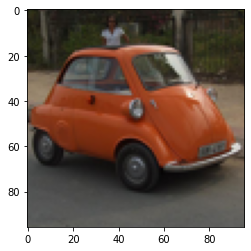

In [52]:
%matplotlib inline 
import matplotlib.pyplot as plt 
plt.imshow(test_image1)